<a href="https://colab.research.google.com/github/ABD-01/Object-Detection/blob/master/OverFeat/RacoonDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import time

import os
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as T

In [ ]:
!git clone https://github.com/datitran/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 29.99 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [ ]:
df = pd.read_csv("/content/raccoon_dataset/data/train_labels.csv")

In [ ]:
df

filename  width  height    class  xmin  ymin  xmax  ymax
0     raccoon-17.jpg    259     194  raccoon    95    60   167   118
1     raccoon-11.jpg    660     432  raccoon     3     1   461   431
2     raccoon-63.jpg    600     400  raccoon    74   107   280   290
3     raccoon-63.jpg    600     400  raccoon   227    93   403   298
4     raccoon-60.jpg    273     185  raccoon    58    33   197   127
..               ...    ...     ...      ...   ...   ...   ...   ...
168  raccoon-137.jpg    320     240  raccoon    71     8   304   233
169  raccoon-171.jpg    224     225  raccoon   108    21   180   115
170  raccoon-190.jpg    259     194  raccoon    78    54   153   135
171   raccoon-22.jpg    640     360  raccoon   252    76   466   335
172  raccoon-152.jpg    275     183  raccoon    41    60   223   155

[173 rows x 8 columns]

In [ ]:
df.filename.unique().shape

(160,)

In [ ]:
sample = df.iloc[9]

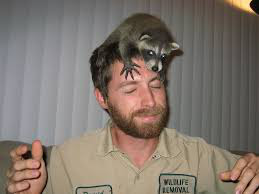

In [ ]:
img = Image.open(os.path.join('/content/raccoon_dataset/images', sample['filename']))
img

In [ ]:
# heights
(df.ymax - df.ymin).mode(), (df.ymax - df.ymin).mean()

(0    150
 dtype: int64, 283.8728323699422)

In [ ]:
# widths
(df.xmax - df.xmin).mode(), (df.xmax - df.xmin).mean()

(0    167
 1    176
 2    198
 dtype: int64, 278.728323699422)

In [ ]:
df["width"].mean(), df["width"].max(), df["width"].min(), df["width"].mode()

(468.0751445086705, 2000, 178, 0    259
 dtype: int64)

In [ ]:
df["height"].mean(), df["height"].max(), df["height"].min(), df["height"].mode()

(368.3757225433526, 1333, 154, 0    194
 dtype: int64)

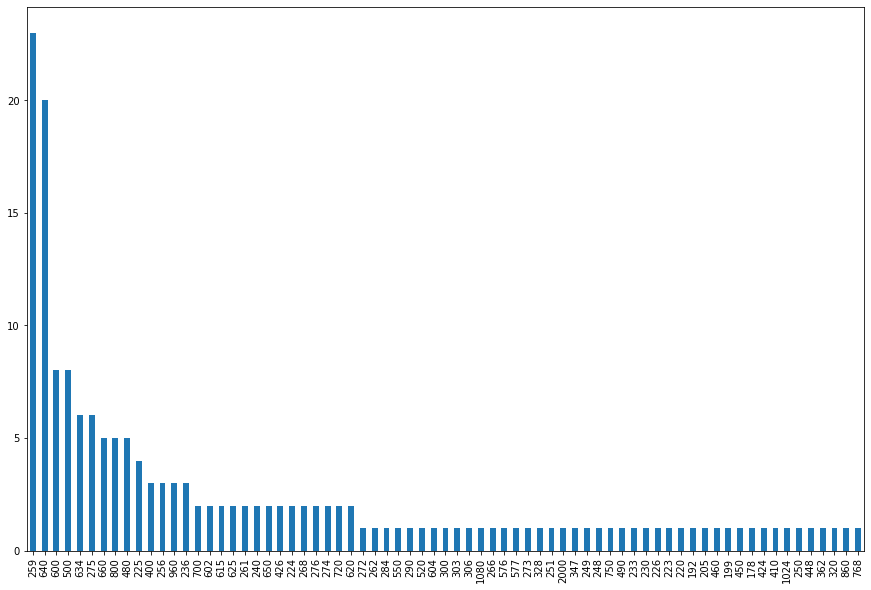

In [ ]:
plt.figure(figsize=(15,10))
df.width.value_counts().plot(kind='bar')
plt.show()

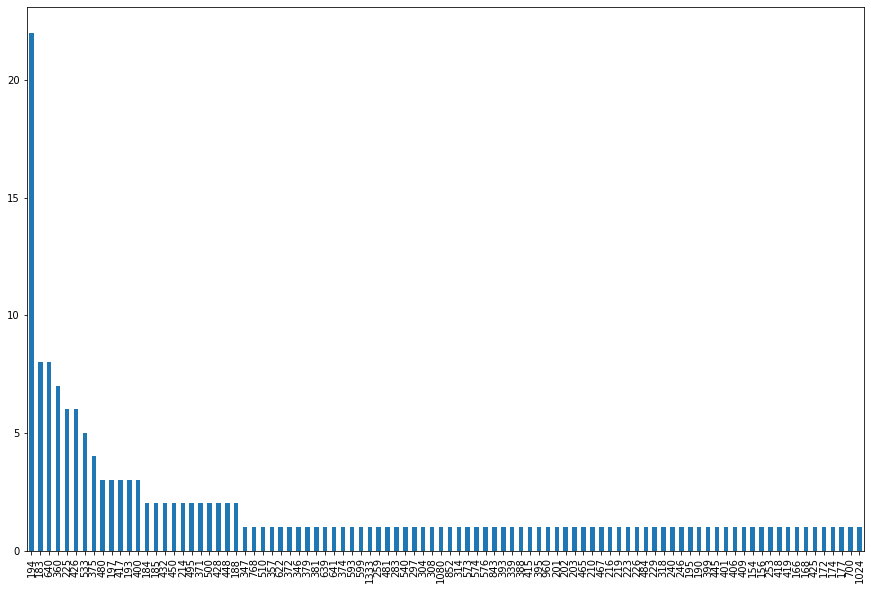

In [ ]:
plt.figure(figsize=(15,10))
df.height.value_counts().plot(kind='bar')
plt.show()

In [ ]:
img_int = (T.ToTensor()(img)).mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8)
ib = torchvision.utils.draw_bounding_boxes(img_int, (torch.Tensor([sample['xmin'], sample['ymin'], sample['xmax'], sample['ymax']])).unsqueeze(0))

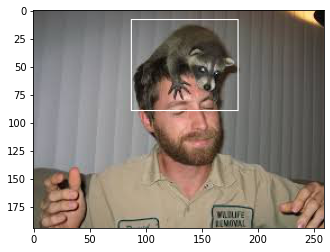

In [ ]:
plt.imshow(ib.permute(1,2,0))

In [ ]:
sample.ymax - sample.ymin, sample.xmax - sample.xmin

(81, 95)

In [ ]:
img.size

(259, 194)

In [ ]:
class RacoonDataset(data.Dataset):
    def __init__(self, root, train=True, transform=None, resize=None):
        '''
        resize (Tuple): (H, W)
        '''
        self.root = root
        self.transform = transform
        self.label_file = os.path.join(self.root, 'data/{}_labels.csv'.format('train' if train else 'test'))

        self.labels = pd.read_csv(self.label_file)
        self.resize = resize


    def __getitem__(self, index):

        row = self.labels.iloc[index]
        img_path = os.path.join(self.root, 'images', row.filename)
        img = self._loader(img_path)

        # traget transform
        if self.resize is not None:
            x_, y_ = img.size

            x_scale = self.resize[1] / x_
            y_scale = self.resize[0] / y_

            # original frame as named values
            orig_xmin, orig_ymin, orig_xmax, orig_ymax = row.xmin, row.ymin, row.xmax, row.ymax


            xmin = int(np.round(orig_xmin * x_scale))
            ymin = int(np.round(orig_ymin * y_scale))
            xmax = int(np.round(orig_xmax * x_scale))
            ymax = int(np.round(orig_ymax * y_scale))

            box = torch.tensor([xmin, ymin, xmax, ymax])
        
        else:
            box = torch.tensor([row.xmin, row.ymin, row.xmax, row.ymax])

        if self.transform is not None:
            image = self.transform(img)

        return image, box

    def _loader(self, path: str) -> Image.Image:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def __len__(self):
        return len(self.labels)

In [ ]:
class OverFeat(nn.Module):
    def __init__(self, pretrained=True):
        super(OverFeat,self).__init__()
        self.featurizer = models.alexnet(pretrained).features
        self.regressor = nn.Sequential(
            nn.Conv2d(256, 1024, 6, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 4, 1, bias=False),
            nn.ReLU(inplace=True)
        )
    
        for m in self.regressor.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.featurizer(x)
        x = self.regressor(x)
        return x

In [ ]:
model = OverFeat()
model

OverFeat(
  (featurizer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Conv2d(256, 1024, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(1024, 512, kernel_size=(1, 1), stri

In [ ]:
MEAN = torch.tensor([0.4472, 0.4330, 0.3732])
STD = torch.tensor([0.2406, 0.2325, 0.2342])

process = T.Compose([
    T.Resize((223, 254)),
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])

In [ ]:
train_data = RacoonDataset(root="/content/raccoon_dataset", transform=process, resize=(223, 254))

In [ ]:
train_data[9][1]

tensor([ 85,   9, 178, 102])

In [ ]:
ToUint8 = T.Compose([
    T.Normalize(0, 1/STD),
    T.Normalize(-MEAN, 1),
    T.ConvertImageDtype(torch.uint8)
])

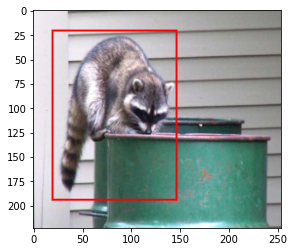

In [ ]:
s = 86
a = torchvision.utils.draw_bounding_boxes(ToUint8(train_data[s][0]), train_data[s][1].unsqueeze(0), width=2, colors='red')
plt.imshow(a.permute(1,2,0))

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [ ]:
model = OverFeat().to(DEVICE, non_blocking=True)

In [ ]:
learning_rate = 0.001/2
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.96)

In [ ]:
criterion = nn.MSELoss(reduction='sum')

In [ ]:
batch_size = 16
train_loader = data.DataLoader(train_data, batch_size, shuffle=True, num_workers=2)

In [ ]:
boxes.dtype, outputs.dtype

(torch.float32, torch.float32)

In [ ]:
model.train()

OverFeat(
  (featurizer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Conv2d(256, 1024, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(1024, 512, kernel_size=(1, 1), stri

In [ ]:
# losses = []
# batch_losses = []
# epoch = 0
Epochs = epoch + 101
for epoch in tqdm(range(epoch, Epochs), leave=False):
    eloss = 0
    for (images, boxes) in train_loader:
        optimizer.zero_grad(True)
        bs = images.shape[0]
        images, boxes = images.to(DEVICE, non_blocking=True), boxes.to(DEVICE, dtype=torch.float32, non_blocking=True)
        outputs = model(images).squeeze()

        loss = torch.div(criterion(outputs, boxes), bs)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        eloss += loss.item()
    losses.append(eloss)
    print(f"Epoch: [{epoch:<4}/{Epochs:<4}] Loss: {eloss:.3f}")

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: [99  /200 ] Loss: 264573.960
Epoch: [100 /200 ] Loss: 96672.835
Epoch: [101 /200 ] Loss: 72666.051
Epoch: [102 /200 ] Loss: 57671.944
Epoch: [103 /200 ] Loss: 55128.528
Epoch: [104 /200 ] Loss: 48615.161
Epoch: [105 /200 ] Loss: 46990.829
Epoch: [106 /200 ] Loss: 37938.782
Epoch: [107 /200 ] Loss: 34194.044
Epoch: [108 /200 ] Loss: 30653.163
Epoch: [109 /200 ] Loss: 30174.443
Epoch: [110 /200 ] Loss: 30705.960
Epoch: [111 /200 ] Loss: 28752.522
Epoch: [112 /200 ] Loss: 27588.417
Epoch: [113 /200 ] Loss: 27592.657
Epoch: [114 /200 ] Loss: 29057.179
Epoch: [115 /200 ] Loss: 27213.707
Epoch: [116 /200 ] Loss: 28539.187
Epoch: [117 /200 ] Loss: 28892.484
Epoch: [118 /200 ] Loss: 28254.380
Epoch: [119 /200 ] Loss: 28237.102
Epoch: [120 /200 ] Loss: 27993.044
Epoch: [121 /200 ] Loss: 27485.104
Epoch: [122 /200 ] Loss: 26754.569
Epoch: [123 /200 ] Loss: 26993.004
Epoch: [124 /200 ] Loss: 26932.157
Epoch: [125 /200 ] Loss: 26942.653
Epoch: [126 /200 ] Loss: 28866.067
Epoch: [127 /200 ] 

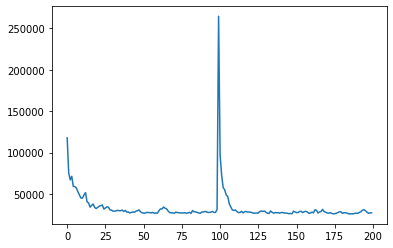

In [ ]:
plt.plot(losses[1:])

In [ ]:
test_data = RacoonDataset(root="/content/raccoon_dataset", transform=process, train=False, resize=(223, 254))

In [ ]:
test_loader = data.DataLoader(test_data, len(test_data))

In [ ]:
test = next(iter(test_loader))

In [ ]:
images , boxes = test

In [ ]:
boxes = boxes.to(DEVICE, dtype=torch.float32)

In [ ]:
model.eval()
output = model(images.to(DEVICE)).squeeze()

In [ ]:
output.shape, boxes.shape

(torch.Size([44, 4]), torch.Size([44, 4]))

In [ ]:
b = torch.stack([output, boxes], dim=1 )
b.shape

torch.Size([44, 2, 4])

In [ ]:
b[s]

tensor([[ 24.7652,   0.0000, 181.9474, 189.1517],
        [  4.0000,   5.0000, 250.0000, 219.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

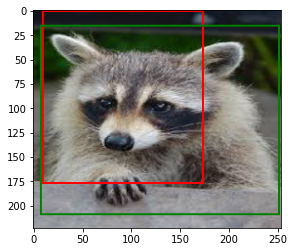

In [ ]:
s = 8
a = torchvision.utils.draw_bounding_boxes(ToUint8(images[s]), b[s], width=2, colors=['red','green'])
plt.imshow(a.permute(1,2,0))

In [ ]:
# torch.save(model, "/content/drive/MyDrive/Colab Notebooks/Object_Detection/model0.pth")

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

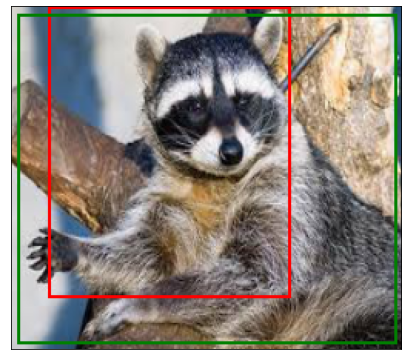

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, ArtistAnimation

# initializing a figure in
# which the graph will be plotted
fig, ax = plt.subplots(figsize=(7,7))

def animate(s):


    a = torchvision.utils.draw_bounding_boxes(ToUint8(images[s]), b[s], width=2, colors=['red','green'])
    ax.imshow(a.permute(1,2,0))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    return s

anim = FuncAnimation(fig, animate, frames = 44, interval = 1000, blit = False)

# plt.show()

# anim.save('ivpreds.gif',writer = 'ffmpeg', fps = 30)



In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
process = T.Compose([
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])
test_data = RacoonDataset(root="/content/raccoon_dataset", transform=process, train=False)

In [ ]:
img, box = test_data[7]

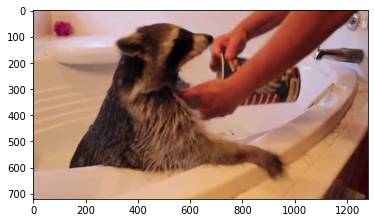

In [ ]:
plt.imshow(ToUint8(img).permute(1,2,0))

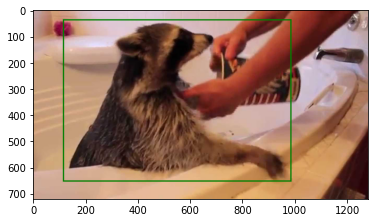

In [ ]:
a = torchvision.utils.draw_bounding_boxes(ToUint8(img), box.unsqueeze(0), width=5, colors='green')
plt.imshow(a.permute(1,2,0))

In [ ]:
r = 1
size = (int(223+(32*r)) , int(254+(32*r)))
img = T.Resize(size)(img)

In [ ]:
img.shape

torch.Size([3, 255, 286])

In [ ]:
out = model(img.unsqueeze(0).cuda())

In [ ]:
out.shape

torch.Size([1, 4, 2, 2])

In [ ]:
out.reshape(4, -1).T.shape

torch.Size([4, 4])

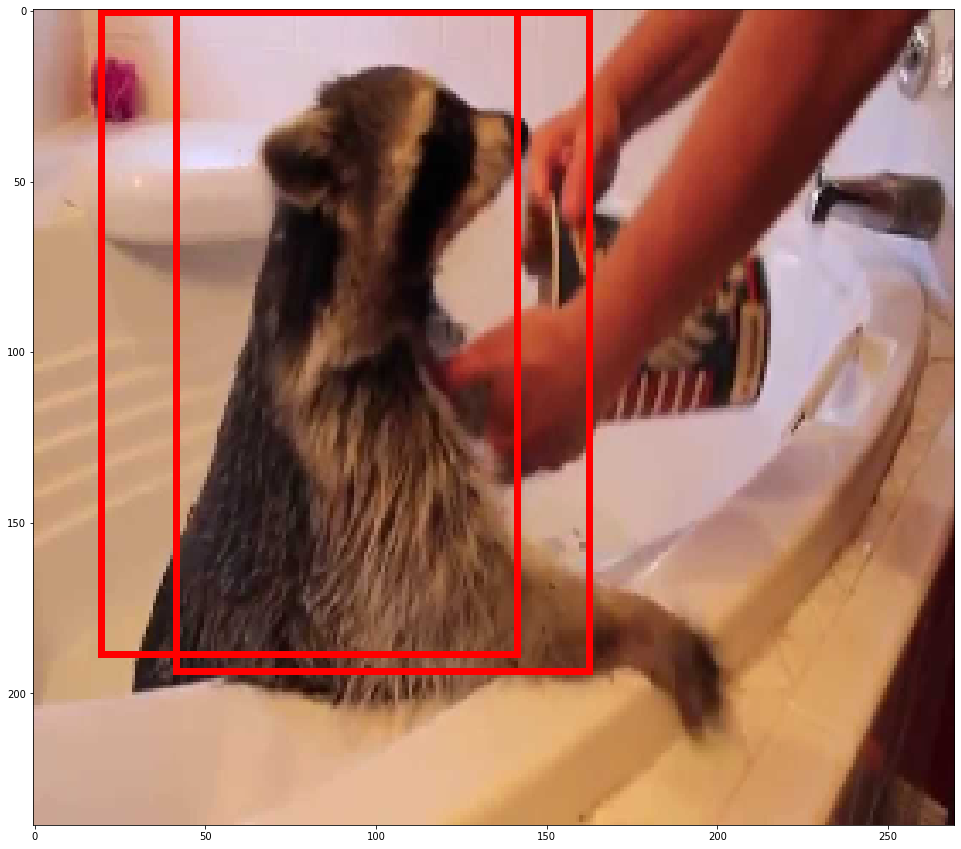

In [ ]:
plt.figure(figsize=(20,15))
a = torchvision.utils.draw_bounding_boxes(ToUint8(img), out.reshape(4, -1).T, width=2, colors='red')
plt.imshow(a.permute(1,2,0))